In [1]:
import root_pandas as rp
import pandas as pd
import ROOT
from ROOT import TVector3, TRandom, TMath
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import torch



Welcome to JupyROOT 6.18/00


In [2]:
# First Load the processed data

df = pd.read_pickle('./processed_data/processed_recoils_0.pk')

In [3]:
# Extract and combine all spacial info

all_x = []
all_y = []
all_z = []

for index, row in df.iterrows():
    all_x += row['x']
    all_y += row['y']
    all_z += row['z']

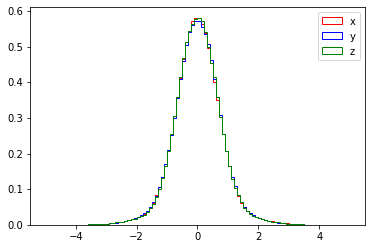

In [4]:
# plot spatial info

plt.figure()
datax = plt.hist(all_x, bins=100, density=True, range =(-5,5), histtype='step',color='r',label ='x')
datay = plt.hist(all_y, bins=100, density=True, range =(-5,5), histtype='step',color='b',label ='y')
dataz = plt.hist(all_z, bins=100, density=True, range =(-5,5), histtype='step',color='g',label ='z')
plt.legend()

The plot above proves the processed data is isotropic

In [5]:
sum( (np.array(all_x) > 2.5) + (np.array(all_x) < -2.5) )/len(all_x)

0.008609872035541522

The number above shows that only a tiny fraction of the data is not contained in -3 < x/y/z < 3

[-0.1031440674043656, 0.9836359562777476, 0.14772138259860967]


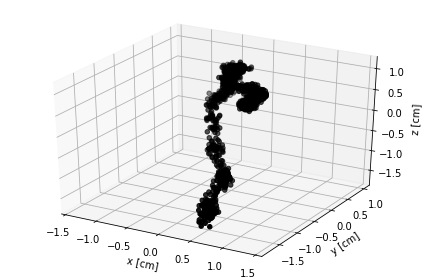

In [3]:
# visualize recoil

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

#select recoil index and obtain data
i = 0
x_i = df.iloc[i]['x']
y_i = df.iloc[i]['y']
z_i = df.iloc[i]['z']
dir_i = df.iloc[i]['dir']

print(dir_i)


# plot full recoil
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')


plt.tight_layout()
ax.scatter3D(x_i, y_i, z_i, c='k', marker='o')

#ax.scatter3D([0,dir_i[0]], [0,dir_i[1]], [0,dir_i[2]], c='r',linestyle='--', s=100)

# Show position of origin
#ax.scatter3D([0], [0], [0], c='r', marker='o',s=100)

axisEqual3D(ax)

In [11]:
# Pixelize the recoil

# x/y/z length being kept in cm in cm
eff_l = 2.5

# voxel size in cm
vox_l = 0.1


#number of pixels along 1 dim
Npix = round(eff_l*2/vox_l) 


# create grid for image
grid = np.zeros((Npix,Npix,Npix,1))

missing = 0

# loop through recoil
for x,y,z in zip(df.iloc[i]['x'],df.iloc[i]['y'],df.iloc[i]['z']):
    
    #obtain index corresponiding to position
    x_ind = int((x+eff_l)/vox_l)
    y_ind = int((y+eff_l)/vox_l)
    z_ind = int((z+eff_l)/vox_l)
    
    if 0<=x_ind<Npix and 0<=y_ind<Npix and 0<=y_ind<Npix:
        grid[x_ind,y_ind,z_ind,0] += 1
        
    else:
        missing += 1
        

print("Amount of missing charge: ", missing) 

Amount of missing charge:  0


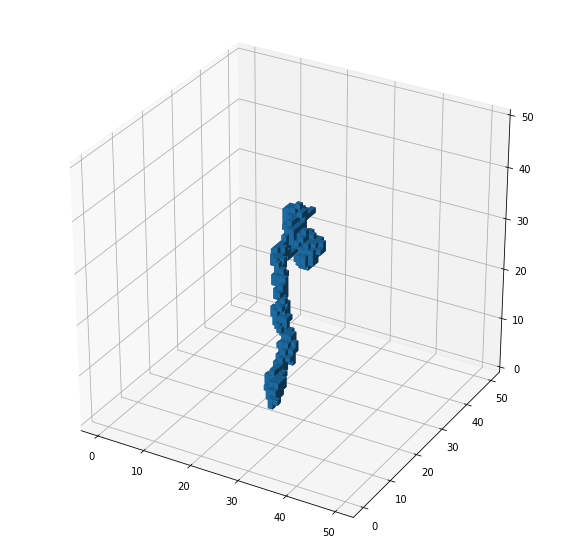

In [12]:
# Show recoil pixelized recoil

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

#w=plt.axis('off')
e=ax.voxels(grid[:,:,:,0])

In [57]:
# Pixelize dataframe
# I only do it for one file now

# x/y/z length being kept in cm in cm
eff_l = 2.5

# voxel size in cm
vox_l = 0.1


#number of pixels along 1 dim
Npix = round(eff_l*2/vox_l) 



labels = []
sparse_tensors = []
dim = (50,50,50,1)


for index, row in df.iterrows():
    
    # Test if recoil escapes effective area
    if np.max(row['x']) >= eff_l or np.min(row['x']) < -eff_l or np.max(row['y']) >= eff_l or np.min(row['y']) < -eff_l or np.max(row['z']) >= eff_l or np.min(row['z']) < -eff_l:
        continue
            
    # create dense tensor for image
    voxelgrid = np.zeros(dim).astype('uint8')
    
    for x,y,z in zip(row['x'],row['y'],row['z']):
        voxelgrid[int((x+eff_l)/vox_l)][int((y+eff_l)/vox_l)][int((z+eff_l)/vox_l)][0] += 1
        
    
    # Convert to pytorch tensor
    voxelgrid = torch.tensor(voxelgrid)
    # Convert to sparse pytorch tensor
    vg = voxelgrid.to_sparse()
    
    # Store sparse tensor and corresponding label 
    sparse_tensors += [vg]
    labels += [row['dir']]        

#I want to use this to only work with sparse tensors (and not lists) but sparse tensor indices cannot be splices
#stacked = torch.stack(sparse_tensors)

# Save sparse tensors and labels
torch.save( sparse_tensors, './sparse_data/sparse_recoils_0.pt')
np.savetxt('./sparse_data/labels_0.pt',labels)

In [58]:
X = np.array(torch.load('./sparse_data/sparse_recoils_0.pt'))
Y = np.loadtxt('./sparse_data/labels_0.pt')


In [59]:
# Break into train and test sets

X_train = X[:3000]
X_test = X[3000:]

Y_train = Y[:3000]
Y_test = Y[3000:]

print(len(X_test),len(X_train))



2672 3000


In [60]:
# The following function is used to serve up both train and validation data.
def data_generator(X, Y, batchsize):
    N = len(X)
    while True:
        indices = np.random.randint(low=0, high=N, size=(batchsize,))
        X1 = X[indices]
        Y1 = Y[indices]
        
        X_dense = []

        # I think this for loop is slowing everything down
        # Try to replace it
        for X_sparse in X1:
            X_dense += [(X_sparse.to_dense()).detach().numpy()]
            
        
        X_dense = np.array(X_dense)
        
        # yield tensors and directions
        yield X_dense, Y1
        
# Create generators.
batchsize  = 100 
data_train = data_generator(X_train, Y_train, batchsize)
data_valid = data_generator(X_test, Y_test, batchsize)

In [61]:
inputs, outputs = data_train.__next__()

inputs.shape

(100, 50, 50, 50, 1)

In [62]:
outputs[0]

array([-0.41867325,  0.72631675,  0.54513914])

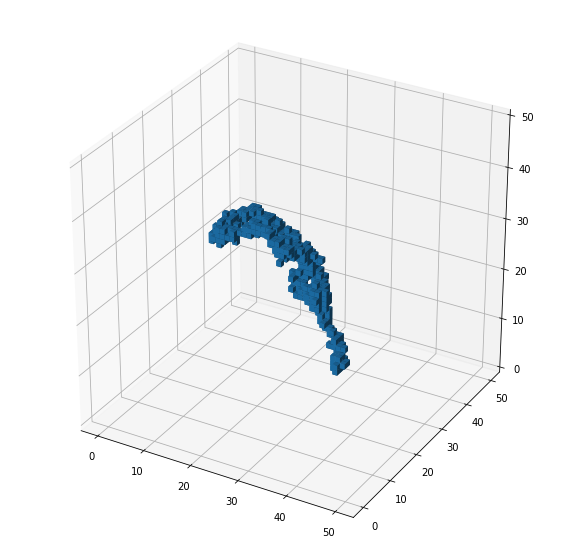

In [63]:
# Show recoil pixelized recoil

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

#w=plt.axis('off')
e=ax.voxels(inputs[0][:,:,:,0])